In [2]:
% matplotlib inline 

import h5py, sys, io, numpy as np
import nibabel as nib
import nibabel.gifti
import nilearn
from nilearn import datasets, plotting
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
mpl.rcParams['svg.fonttype'] = 'none'

In [3]:
surfmL = nib.freesurfer.read_geometry('gradient_data/templates/Q1-Q6_R440.L.midthickness.32k_fs_LR.surf')
surfiL = nib.freesurfer.read_geometry('gradient_data/templates/Q1-Q6_R440.L.very_inflated.32k_fs_LR.surf')
surfL = []
surfL.append(np.array(surfmL[0]*0.3 + surfiL[0]*0.7))
surfL.append(surfmL[1])

surfmR = nib.freesurfer.read_geometry('gradient_data/templates/Q1-Q6_R440.R.midthickness.32k_fs_LR.surf')
surfiR = nib.freesurfer.read_geometry('gradient_data/templates/Q1-Q6_R440.R.very_inflated.32k_fs_LR.surf')
surfR = []
surfR.append(np.array(surfmR[0]*0.3 + surfiR[0]*0.7))
surfR.append(surfmR[1])

sulcL = -1 * nib.load('gradient_data/templates/Q1-Q6_R440.sulc.32k_fs_LR.dscalar.nii').data[0:32492]
sulcR = -1 * nib.load('gradient_data/templates/Q1-Q6_R440.sulc.32k_fs_LR.dscalar.nii').data[32492:32492*2]

res = nib.load('gradient_data/templates/hcp.embed.all.179.lh.dscalar.nii').data
cortL = np.squeeze(np.array(np.where(res != 0)[0], dtype=np.int32))
res = nib.load('gradient_data/templates/hcp.embed.all.179.rh.dscalar.nii').data
cortR = np.squeeze(np.array(np.where(res != 0)[0], dtype=np.int32))
cortLen = len(cortL) + len(cortR)
del res

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [4]:
emb = np.load('gradient_data/embedded/embedding_dense_cosine_emb.npy')

## Yeo7 networks 

In [5]:
yeo7L = nib.gifti.read('gradient_data/templates/hcp.RSN.L.gii').darrays[0].data
yeo7R = nib.gifti.read('gradient_data/templates/hcp.RSN.R.gii').darrays[0].data
yeo17L = nib.gifti.read('gradient_data/templates/hcp.RSN.L.gii').darrays[1].data
yeo17R = nib.gifti.read('gradient_data/templates/hcp.RSN.R.gii').darrays[1].data

In [6]:
yeo7 = np.concatenate((yeo7L[cortL], yeo7L[cortR]))
uniqueY = np.array(np.unique(yeo7), dtype=np.int32)[1::]
sz = len(uniqueY)
rsns={}
for c in range(sz):
    rsns['k'+str(int(c)+1)]=[]

r = []     
for x in range(sz):
    g = emb[np.where(yeo7 == uniqueY[x]),0]
    for y in g[0]:
        if y != 0:
            rsns['k'+str(int(x)+1)].append(float(y))
    r.append(np.mean(rsns['k'+str(int(x)+1)]))

ord = np.argsort(r)

plot_list=[]
for c in range(sz):    
    plot_list+=[np.squeeze(rsns['k'+str(ord[c]+1)])]

names=[]
for c in range(sz):
    names.append(str(int(ord[c])+1))

convertYeo7 = [2,5,6,0,4,1,3] 
cols7 = ((255,255,255),
         (120,  18, 134),
         (70 ,130, 180),
         ( 0 ,118 , 14),
         (196 , 58 ,250),
         (220 ,248 ,164),
         (230, 148,  34),
         (205 , 62,  78 ))
cols = cols7
cols = np.asarray(cols, dtype=float)/255
yeoCols = ListedColormap(cols,name='colormapYeo')

colors1 = list()
for i in xrange(0,len(ord)):
    colors1.append(tuple(cols[convertYeo7[ord[i]] + 1]))

In [7]:
height=10
sns.set_context('notebook', font_scale=1.8)
sns.axes_style("white")
sns.set_palette(colors1)

fig = plt.figure(figsize=(20,height))
ax = sns.boxplot(data=plot_list, saturation=0.5, orient='h', flierprops=dict(marker='+', markersize=2, 
                                                                             color="gray", markeredgecolor="gray"))
ax.set_yticklabels('')
sns.axlabel('Gradient Values','', fontsize=22)
plt.savefig('gradient_data/figures/yeo_dist_plot.png')
plt.close(fig)

fig, axarr = plt.subplots(nrows=sz, ncols=1, figsize=(2*(20/sz),height))
data = datasets.fetch_atlas_yeo_2011(data_dir='gradient_data/templates/')
yeoV7 = nibabel.load(data.thick_7)
y = 0
for x in range(sz):
    yeoV7_1 = nibabel.Nifti1Image((yeoV7.get_data() == convertYeo7[ord[x]] + 1).astype(int), yeoV7.get_affine())     
    yeoCols = ListedColormap(cols[[0,convertYeo7[ord[x]] + 1]],name='colormapYeo')
    plotting.plot_glass_brain(yeoV7_1, axes=axarr[x], annotate=False, alpha=0.3, cmap=yeoCols, threshold=0.1, 
                          output_file='gradient_data/figures/yeo_brains.png')
    y += 1

from PIL import Image
i1 = Image.open('gradient_data/figures/yeo_dist_plot.png')
i2 = Image.open('gradient_data/figures/yeo_brains.png')
result = Image.new("RGBA", (np.shape(i1)[1]+50, np.shape(i1)[0]))
result.paste(i1, (120, 0))
result.paste(i2, (0, 0))
result.save('gradient_data/figures/Yeo7_Fig.png')

/Applications/miniconda3/envs/topography/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



Dataset created in ./yeo_2011



Downloaded 2654759 of 2654759 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)
Extracting data from ./yeo_2011/0bd88054bb0534c5570c87970a74e8e8/Yeo_JNeurophysiol11_MNI152.zip..... done.


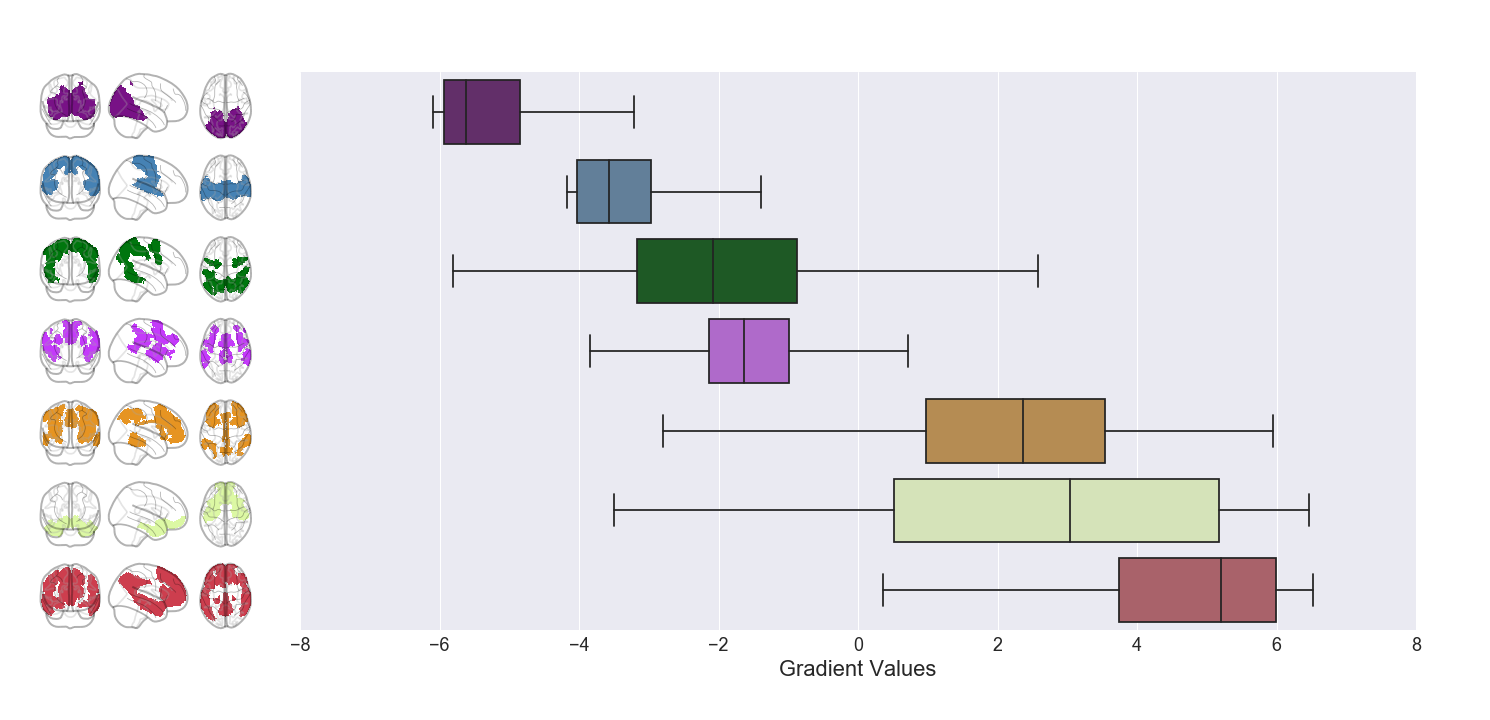

In [9]:
from IPython.display import Image as im
im(filename='gradient_data/figures/Yeo7_Fig.png') 

In [11]:
import sys
sys.path.append('gradient_data/src/')
from viz import *

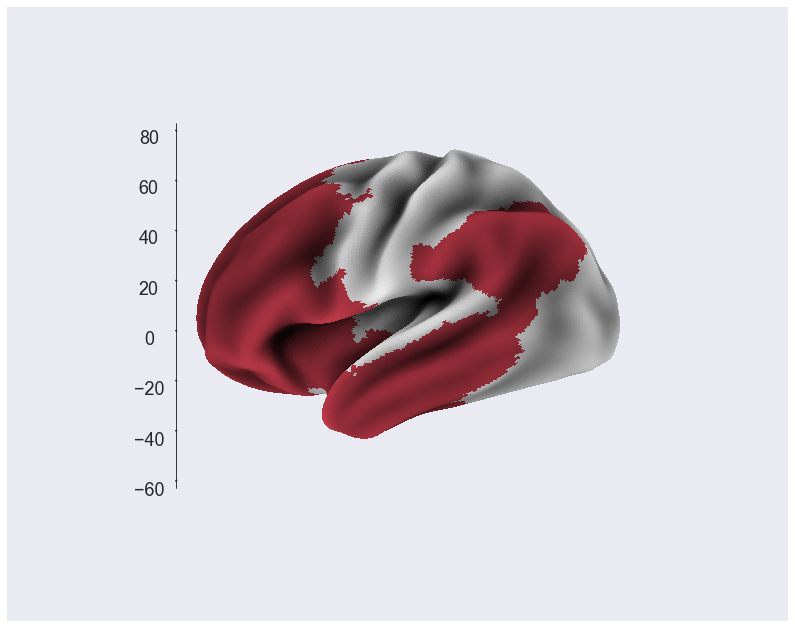

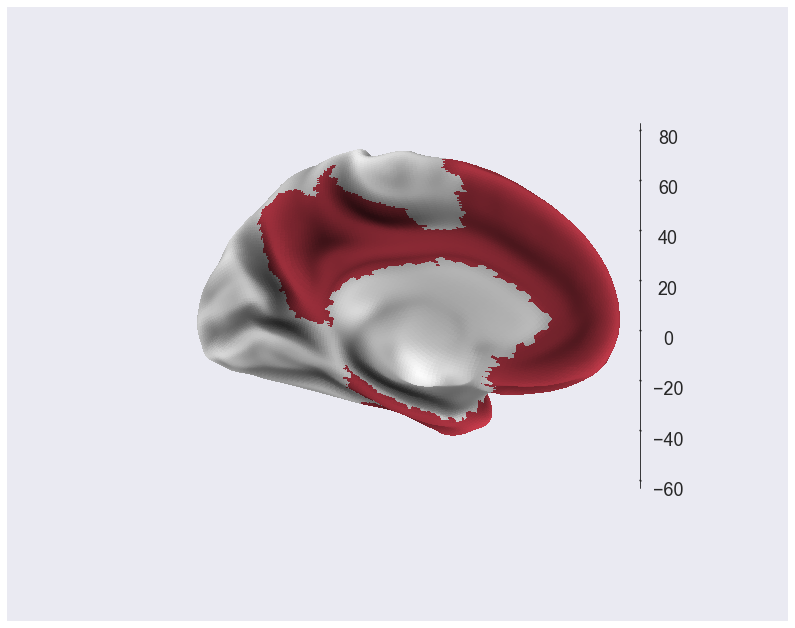

In [12]:
y = yeo7L.copy()
for n, v in enumerate(uniqueY):
    y[yeo7L == v] = int(convertYeo7[n]) - 3
y[yeo7L == 37] = - 4
c = np.where([yeo17L != 37])[1]
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, mask=c, bg_on_stat=True, stat_map=y, azim=0, alpha=1, cmap=yeoCols, label=True)
plt.show()
f.savefig('gradient_data/figures/yeo7.lat.png')
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, mask=c, bg_on_stat=True, stat_map=y, azim=180, alpha=1, cmap=yeoCols, label=True)
plt.show()
f.savefig('gradient_data/figures/yeo7.med.png')

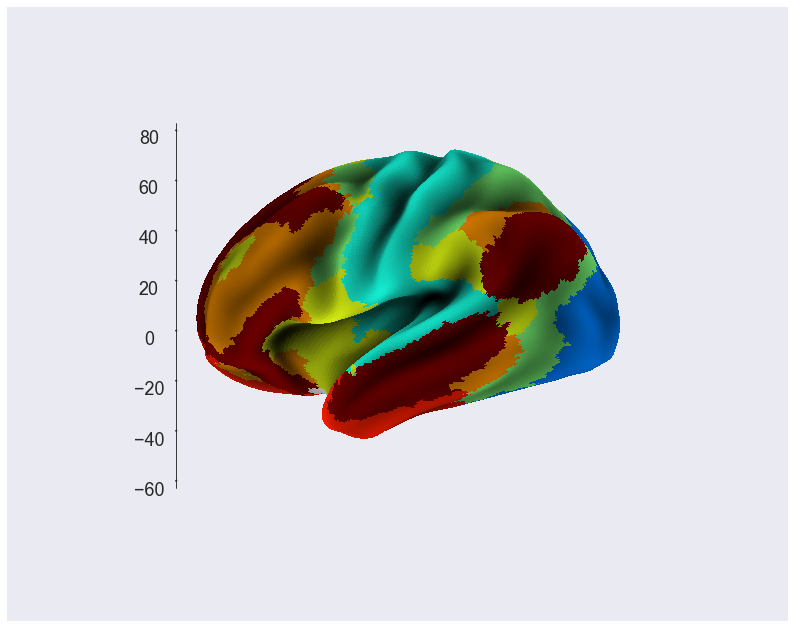

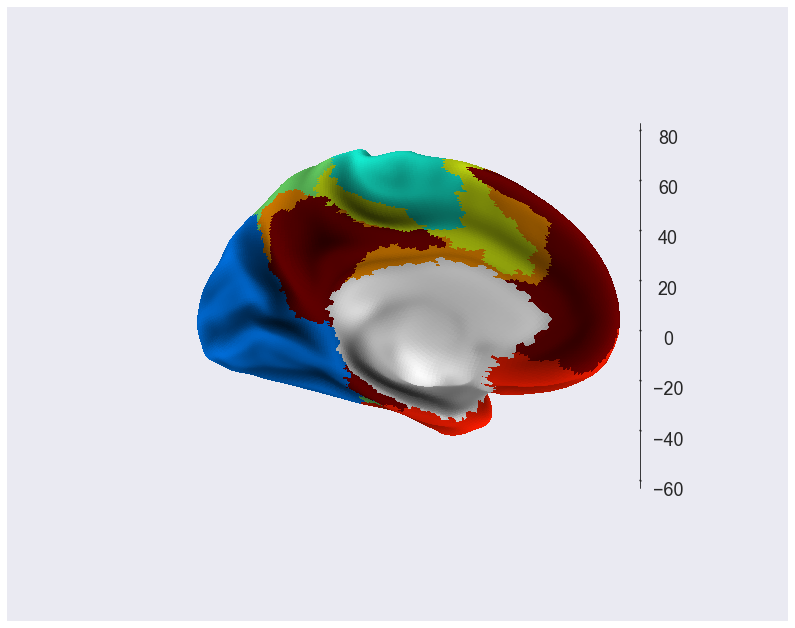

In [13]:
# plot order on surface
y = yeo7L.copy()
ord1 = np.argsort(ord)
for n, v in enumerate(uniqueY):
    y[yeo7L == v] = int(ord1[n]) + 1 - 3
y[yeo7L == 37] = - 4
c = np.where([yeo17L != 37])[1]
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, stat_map=y, mask=c, bg_on_stat=True, azim=0, alpha=1, label=True)
plt.show()
f.savefig('gradient_data/figures/yeo7.reord.lat.png')
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, stat_map=y, mask=c, bg_on_stat=True, azim=180, alpha=1, label=True)
plt.show()
f.savefig('gradient_data/figures/yeo7.reord.med.png')

## Yeo17 networks